# Module 00: Data Pre-Processing & Feature Selection

## Importing Libraries and Modules 

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

## Data Import

In [3]:
# Load data and prepare features
data = pd.read_csv('data.csv')
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

## Feature Importance Ranking

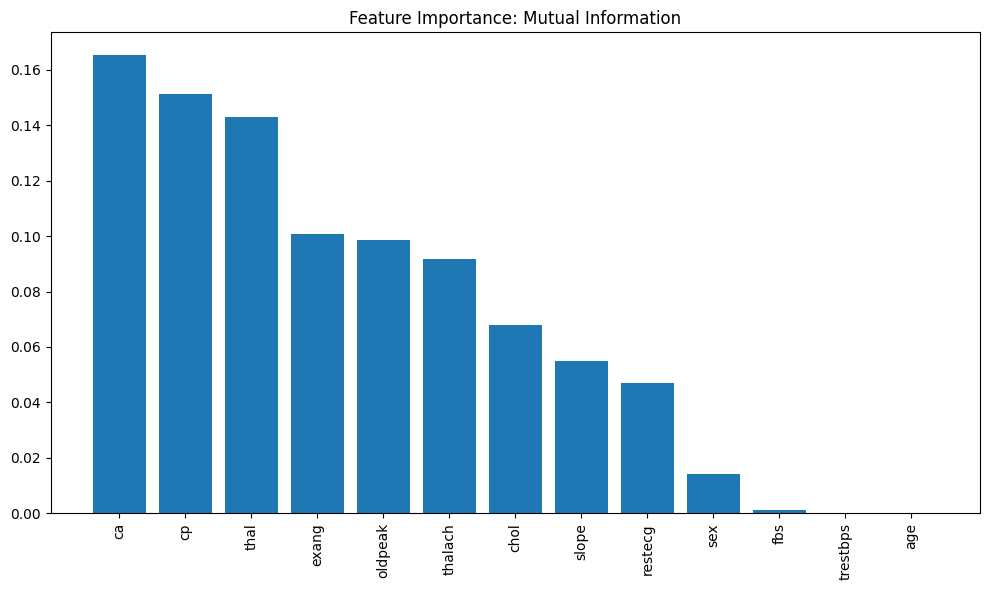


Mutual Information:
      Feature  Mutual Information
11        ca            0.165261
2         cp            0.151111
12      thal            0.142909
8      exang            0.100706
9    oldpeak            0.098591
7    thalach            0.091774
4       chol            0.068051
10     slope            0.054787
6    restecg            0.046949
1        sex            0.014296
5        fbs            0.001074
3   trestbps            0.000000
0        age            0.000000


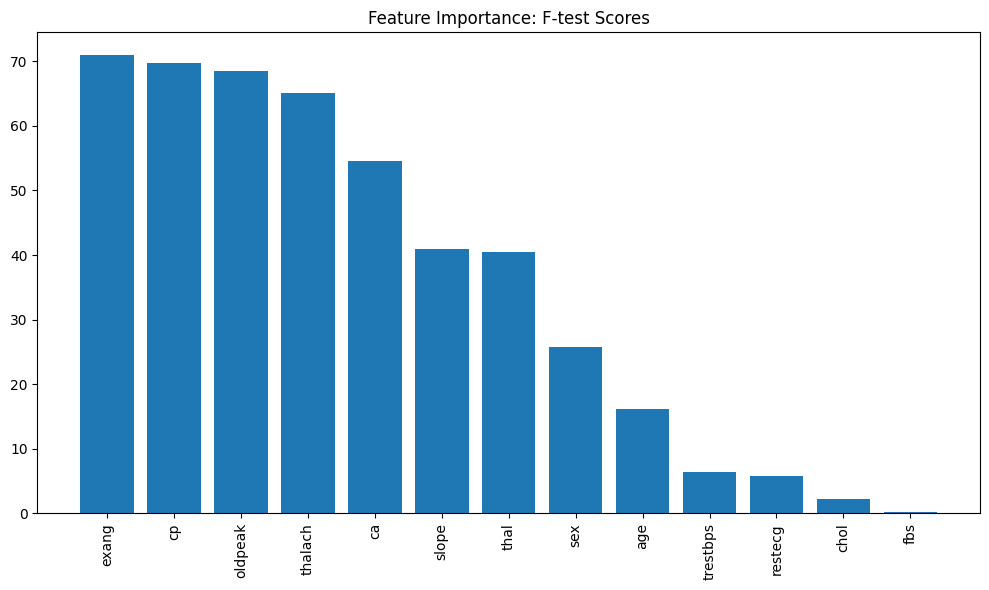


F-test Scores:
      Feature  F-test Score
8      exang     70.952438
2         cp     69.772271
9    oldpeak     68.551439
7    thalach     65.120104
11        ca     54.559834
10     slope     40.902071
12      thal     40.407696
1        sex     25.792191
0        age     16.116700
3   trestbps      6.458169
6    restecg      5.777209
4       chol      2.202983
5        fbs      0.236942


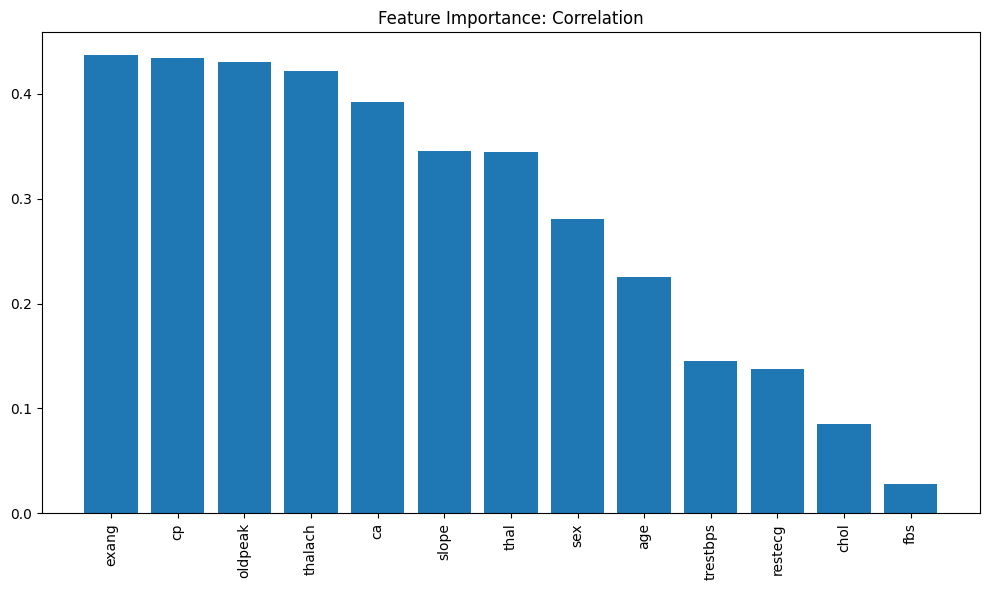


Correlation:
      Feature  Correlation
8      exang     0.436757
2         cp     0.433798
9    oldpeak     0.430696
7    thalach     0.421741
11        ca     0.391724
10     slope     0.345877
12      thal     0.344029
1        sex     0.280937
0        age     0.225439
3   trestbps     0.144931
6    restecg     0.137230
4       chol     0.085239
5        fbs     0.028046


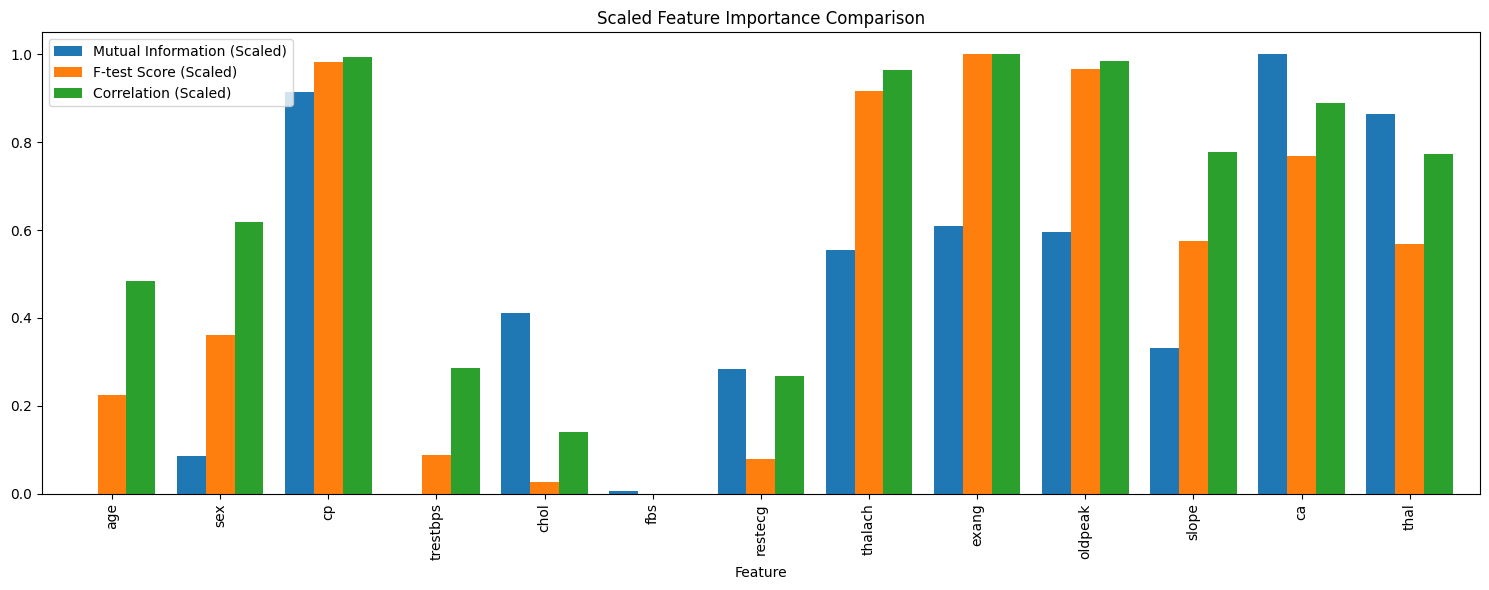

In [4]:
# Calculate all metrics at once
metrics = {
    'Mutual Information': mutual_info_classif(X, y),
    'F-test Score': f_classif(X, y)[0],
    'Correlation': data.corrwith(y).abs().drop(y.name).values
}

# Create unified DataFrame
feature_importance = pd.DataFrame({'Feature': X.columns})
for name, values in metrics.items():
    feature_importance[name] = values

# Generic plotting function
def plot_metric(metric, title):
    df = feature_importance.sort_values(metric, ascending=False)
    plt.figure(figsize=(10, 6))
    plt.bar(df['Feature'], df[metric])
    plt.title(f'Feature Importance: {title}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    return df

# Plot and display results for each metric
for metric, title in [('Mutual Information', 'Mutual Information'),
                      ('F-test Score', 'F-test Scores'),
                      ('Correlation', 'Correlation')]:
    sorted_df = plot_metric(metric, title)
    print(f"\n{title}:\n", sorted_df[['Feature', metric]])

# Combined comparison plot
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(feature_importance.iloc[:, 1:]),
                      columns=[f"{col} (Scaled)" for col in metrics],
                      index=feature_importance.Feature)

ax = scaled.plot.bar(figsize=(15, 6), width=0.8)
plt.title('Scaled Feature Importance Comparison')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## Dimensionality Reduction using PCA

In [6]:
# Standardize features
scaler = StandardScaler()
standardized_data = scaler.fit_transform(data.drop('target',axis=1))

# Apply PCA
pca = PCA(n_components=2)  # Example with 2 components
principal_components = pca.fit_transform(standardized_data)

# Get the loadings (coefficients) for each feature in each component
loadings = pca.components_

# Select features based on loadings
# For example, select features with the highest absolute loading in the first component
feature_importances = np.abs(loadings[0])
top_features = np.argsort(feature_importances)[::-1][:8]  # Select top 8 features

# Use these original features for your model
selected_features = data.iloc[:, top_features]

selected_features

,oldpeak,thalach,slope,exang,age,cp,ca,thal
0,2.3,150,0,0,63,3,0,1
1,3.5,187,0,0,37,2,0,2
2,1.4,172,2,0,41,1,0,2
3,0.8,178,2,0,56,1,0,2
4,0.6,163,2,1,57,0,0,2
...,...,...,...,...,...,...,...,...
298,0.2,123,1,1,57,0,0,3
299,1.2,132,1,0,45,3,0,3
300,3.4,141,1,0,68,0,2,3
301,1.2,115,1,1,57,0,1,3


## Wrapper Methods

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize a Random Forest Classifier
model = RandomForestClassifier(random_state=42)

# Use Recursive Feature Elimination (RFE) for Wrapper Method
rfe = RFE(estimator=model, n_features_to_select=6)  # Selecting top 6 features
rfe.fit(X_train, y_train)

# Get the selected features
selected_features_wrapper = X.columns[rfe.support_]
print("Selected features using Wrapper Method:", selected_features_wrapper.tolist())


Selected features using Wrapper Method: ['age', 'cp', 'thalach', 'oldpeak', 'ca', 'thal']


## Embedded methods

Selected features using Embedded Method: ['sex', 'cp', 'restecg', 'exang', 'slope', 'ca', 'thal']


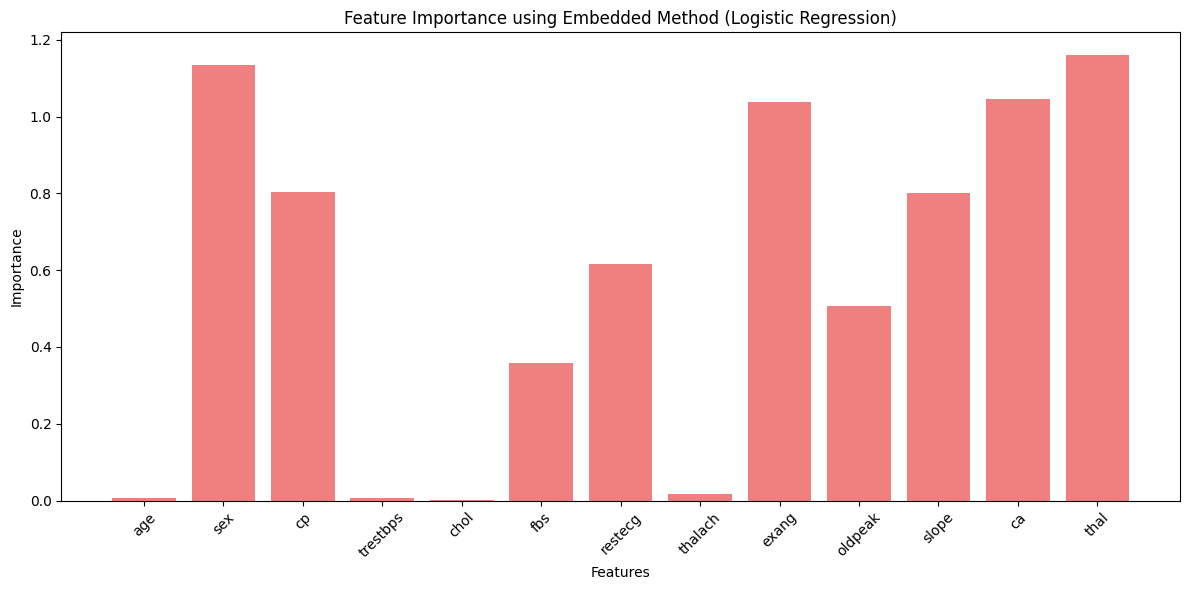

In [8]:
# Initialize a Logistic Regression model
logistic_model = LogisticRegression(random_state=42, max_iter=1000)

# Use SelectFromModel for Embedded Method
sfm = SelectFromModel(estimator=logistic_model)
sfm.fit(X_train, y_train)

# Get the selected features
selected_features_embedded = X.columns[sfm.get_support()]
print("Selected features using Embedded Method:", selected_features_embedded.tolist())

# Plot feature importance (absolute values of coefficients)
importance = abs(sfm.estimator_.coef_[0])  # Get absolute values of coefficients
plt.figure(figsize=(12, 6))
plt.bar(X.columns, importance, color='lightcoral')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance using Embedded Method (Logistic Regression)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
